Annoy is an in-memory cpu-only approximate nearest neighbor index which I'm using in this demo.

We will be running some performance experiments by grid searching over two Annoy parameters, `n_trees` and `search_k` assuming the dataset size is constant and assuming a fixed latency bugdet (off the top of my head 1-2ms should be reasonable).

The parameters are explained in more detail in https://github.com/spotify/annoy#tradeoffs.

This notebook assumes you have a prepared encoder and a directory of wav files.

In [19]:
%load_ext autoreload
%autoreload 2

!pip3 install -q pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from pathlib import Path
import time

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from tqdm.notebook import tqdm

import boiler.index
import boiler.dataset

In [4]:
class args:
    wav_dir = Path('/home/proger/coub-crawler/monthlyLog/wav')
    encoder = Path('/home/proger/boiler/exp/p_t64_b512/vqvae_223/BagTopVQVAE/encoder.pt')
    index_dir = Path('/home/proger/boiler/annoy')
    device = 'cuda'

In [5]:
coubs = sorted(args.wav_dir.glob('*.wav'))
coub_dataset = ConcatDataset([boiler.dataset.WavFile(wav) for wav in coubs])
coub_loader = DataLoader(coub_dataset, batch_size=64, shuffle=False, num_workers=4)

In [6]:
model = torch.jit.load(str(args.encoder))

In [7]:
embeddings = []
for batch in tqdm(coub_loader):
    embeddings.append(model(batch.to(args.device)).detach().cpu())
embeddings = torch.cat(embeddings)

/home/proger/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:727: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  result = self.forward(*input, **kwargs)



Tuning guidelines:

> Basically it's recommended to set `n_trees` as large as possible given the amount of memory you can afford,
> and it's recommended to set `search_k` as large as possible given the time constraints you have for the queries.

`search_k` defaults to `n*n_trees`.

In [11]:
experiments = []

n = 10
query = embeddings[1]  # maybe try more queries?
baseline_result = (1 - F.cosine_similarity(query.unsqueeze(0), embeddings)).argsort(descending=False)[:n].tolist()

for n_trees in tqdm([5, 10, 20, 50, 100, 200, 300, 500, 1000]):
    index, path = boiler.index.make_index(embeddings, args.index_dir, n_trees)
    size = path.stat().st_size
    
    for search_k in tqdm([n*n_trees//2, n*n_trees, 2*n*n_trees, 3*n*n_trees, 10*n*n_trees]):
        def run():
            a = time.perf_counter()
            result = index.get_nns_by_vector(query, n=n, search_k=search_k, include_distances=False)
            b = time.perf_counter()
            recall = len(set(baseline_result).intersection(set(result)))/len(baseline_result)
            return b-a, recall
        
        stats = torch.tensor([run() for _ in range(1000)])
        latency, recall = stats.mean(dim=0).tolist()
        latency_std, recall_std = stats.std(dim=0).tolist()
        
        experiments.append(dict(n_trees=n_trees,
                                 search_k=search_k,
                                 size=size,
                                 latency=latency, latency_std=latency_std,
                                 recall=recall, recall_std=recall_std))
    del index

In [24]:
pd.set_option('display.max_rows', 500)
df = pd.DataFrame(experiments)
df

,n_trees,search_k,size,latency,latency_std,recall,recall_std
0,5,25,3279248,0.000121,0.000013,0.5,0.0
1,5,50,3279248,0.000122,0.000017,0.5,0.0
2,5,100,3279248,0.000125,0.000017,0.5,0.0
3,5,150,3279248,0.000125,0.000011,0.5,0.0
4,5,500,3279248,0.000139,0.000035,0.6,0.0
5,10,50,4062076,0.000134,0.000033,0.5,0.0
6,10,100,4062076,0.000124,0.000020,0.5,0.0
7,10,200,4062076,0.000127,0.000020,0.5,0.0
8,10,300,4062076,0.000129,0.000014,0.5,0.0
9,10,1000,4062076,0.000175,0.000039,0.6,0.0


I will be dropping all runs that have even a slightest drop in recall:

In [25]:
df = df[~(df.recall < 1)]

Annoy mmaps a single index only once into the memory and it can be shared between multiple workers. We only need to make sure a single copy fits into our RAM budget assuming the dataset size is constant.

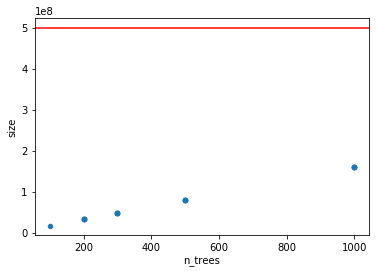

In [33]:
df.plot.scatter(x='n_trees', y='size')
plt.axhline(0.5*1e9, color='red', label='ram cap (0.5 gigabytes)')

,n_trees,search_k,size,latency,latency_std,recall,recall_std
29,200,20000,34177236,0.001300,0.000110,1.0,0.0
34,300,30000,50003440,0.001856,0.000171,1.0,0.0
37,500,10000,81705964,0.001074,0.000087,1.0,0.0
38,500,15000,81705964,0.001288,0.000052,1.0,0.0
40,1000,5000,161147596,0.001164,0.000410,1.0,0.0
41,1000,10000,161147596,0.001519,0.000124,1.0,0.0


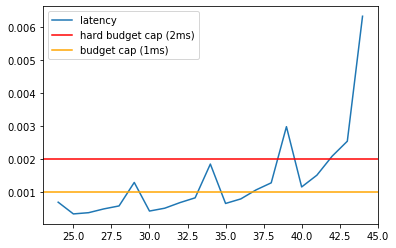

In [31]:
df.latency.plot()
plt.axhline(0.002, color='red', label='hard budget cap (2ms)')
plt.axhline(0.001, color='orange', label='budget cap (1ms)')
plt.legend()

df[(df.latency<0.002) & (df.latency>0.001)]

If there are no more considerations, we're good to go with any of the models above.